# Обработка и распознавание изображений
## Отчет по лабораторной работе №2
### 1.	Постановка задачи

Разработать и реализовать программу для классификации изображений моделей графов, построенных из магнитной головоломки, обеспечивающую:
• Ввод и отображение на экране изображений в формате JPEG;<br>
• Сегментацию изображений на основе точечных и пространственных преобразований;<br>
• Генерацию признаковых описаний структуры графов на изображениях;<br>
• Построение классификатора изображения в соответствии с заданным набором эталонов.<br>
Была выбрана задача класса Intermediate: разработать алгоритм, который сможет классифицировать тестовые картинки по всем 4 типам графа для изображений на белом фоне.

### 2.	Описание данных
В качестве исходных данных прилагается набор из 8 цветных изображений моделей, построенных из деталей магнитной игры-головоломки в формате 1024×768 с разрешением 72 dpi. Всего задано 4 структуры графа, эталоны которых представлены на изображениях 2.jpg (класс I), 3.jpg (класс II), 4.jpg (класс III), 5.jpg (класс IV). На остальных изображениях
представлены графы, изоморфные четырём эталонным образцам 13.jpg (класс I), 25.jpg (класс II), 19.jpg (класс III), 7.jpg (класс IV).
<br>
### 3.	Описания метода решения, программной реализации и проведенных экспериментов для осуществления реализации программы
**1) Построение скелета графа** <br>
Для начала необходимо выполнить обратную бинаризацию изображения. Порог бинаризации 80 подбирался эмпирически. Затем необходимо сгладить границу бинарного изображения и заполнение "дырок" в получившейся маске графа . Это делается с помощью дилатации кистью диаметра 9. После описанных выше преобразований строится скелет получившегося бинарного изображения. Построение кисти реализовано функцией create_brush(d). <br>


In [10]:
def create_brush(d):
    brush = np.zeros((d, d), dtype=np.uint8)
    cv2.circle(brush, (d // 2, d // 2), d // 2, 1, -1)
    return brush

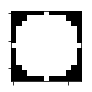

In [11]:
plot_image(create_brush(13),zoom=0.2)

дилатация бинарного изображения:


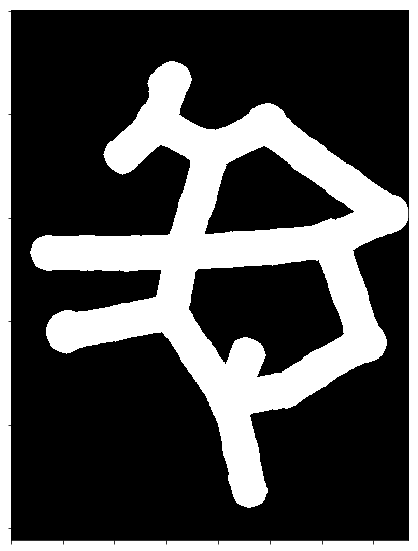

скелет бинарного изображения:


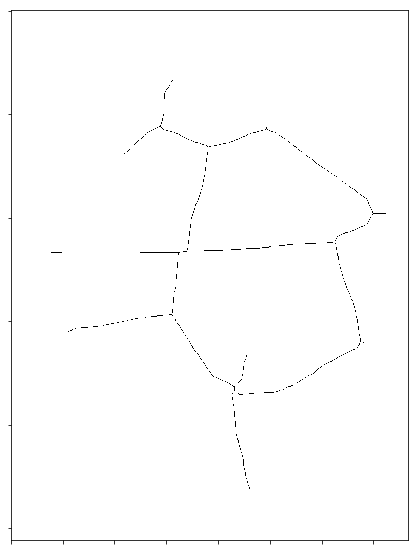

In [17]:
from skimage.morphology import skeletonize
filename="5.jpg"
img = cv2.imread(filename, 0)
_, img_mask = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY_INV)#обратная бинаризация
img = cv2.dilate(img_mask, kernel=create_brush(13), iterations=2)#дилатация
print("дилатация бинарного изображения:")
plot_image(img)
skeleton = skeletonize(img > 0)#построение скелета
skeleton_raw = skeleton.copy()
skeleton=skeleton.astype(np.uint8)*255
skeleton=cv2.bitwise_not(skeleton)
print("скелет бинарного изображения:")
plot_image(skeleton)

**2) Поиск вершин графа** <br>
Поиск вершин в графе выполнялся объединением двух способов. <br>
***2a) Поиск концевых точек скелета*** <br>
Такой способ реализуется с помощью функции skeleton_endpoints(), которая размывает подаваемое на вход изображение скелета путем свертывания  ядром.

In [18]:
skel = skeleton_raw.copy()
skel[skel > 0] = 1
skel = skel.astype(np.uint8)
kernel = np.array(
    [[1,  1, 1],
     [1, 10, 1],
     [1,  1, 1]], dtype=np.uint8)
filtered = cv2.filter2D(skel, -1, kernel)

С такой сверткой значение на концевых точках скелета будет равно 11, а в остальных точках 12 или больше, потому что будет 2 или больше соседей. Для точек, не принадлежащих скелету - меньше 10.
Возможны только такие ситуации для концевых точек скелета:

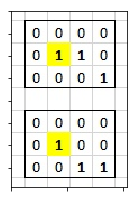

In [19]:
img = cv2.imread("o1.jpg", 1)
plot_image(img,zoom=0.5)

И не возможны такие:

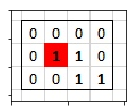

In [21]:
img = cv2.imread("o2.jpg", 1)
plot_image(img,zoom=0.4)

In [22]:
def skeleton_endpoints(skeleton, neighbours=1):
    skeleton = skeleton.copy()
    skeleton[skeleton > 0] = 1
    skeleton = skeleton.astype(np.uint8)

    kernel = np.array(
        [[1,  1, 1],
         [1, 10, 1],
         [1,  1, 1]], dtype=np.uint8)
    filtered = cv2.filter2D(skeleton, -1, kernel)
     #С такой сверткой значение на концах будет равно 11, а в остальных точках 12 или больше, 
     #потому что будет 2 или больше соседей. Для точек, не принадлежащих скелету - меньше 10

    result = np.zeros(skeleton.shape)
    result[np.where(filtered == 10 + neighbours)] = 1 #Значения тех точек, которые интерпретируются как концевые, 
    return result, filtered                                     #приравниваются к 1


Скелет после применения свертки:


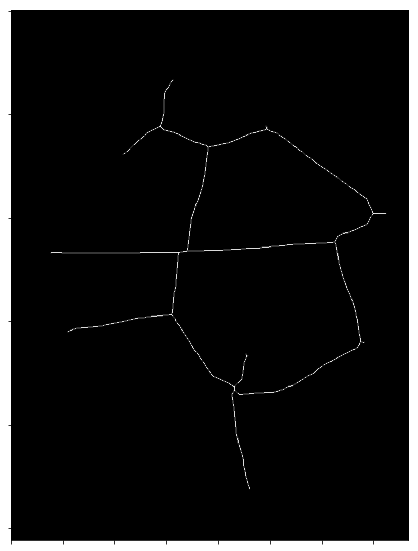

Концевые точки скелета отмечены красным цветом:


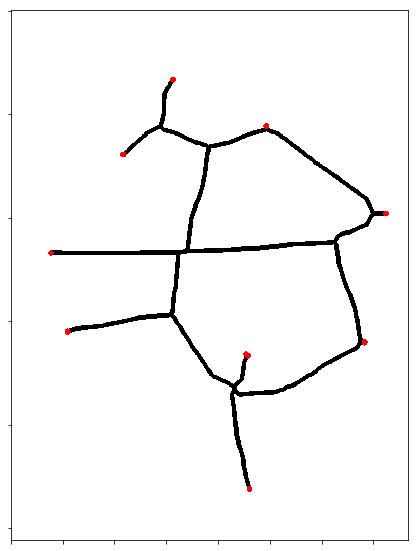

In [24]:
from skimage.color import gray2rgb
result, filtered=skeleton_endpoints(skeleton_raw)
print("Скелет после применения свертки:")
plot_image(filtered)
points =np.where(result!=0)
skel_pix=skeleton_raw.copy()
skel_pix = scale_image_pixels(skel_pix)#Увеличиваем толщину скелета
skel_pix = cv2.dilate(skel_pix, create_brush(9))
skel_pix = scale_image_pixels(skel_pix)
skel_pix=cv2.bitwise_not(skel_pix)
img_color = gray2rgb(skel_pix)

img_tmp = scale_image_pixels(result)
img_tmp = cv2.dilate(img_tmp, create_brush(7), iterations=2)

img_color[np.where(img_tmp > 0)] = (0, 0, 255)

print("Концевые точки скелета отмечены красным цветом:")
plot_image(img_color)

***2b) Определение расположения магнитных шариков (нетерминальных вершин графа)*** <br>
Предыдущий способ подходил для нахождения "внешних" графа. Для поиска "внутренних" определялись расположения магнитных шариков.
Для нахождения кругов на изображении в оттенках серого использовалось преобразование Хафа. Минимальный и максимальный радиусы подбирались, ориентируясь на размеры шариков.

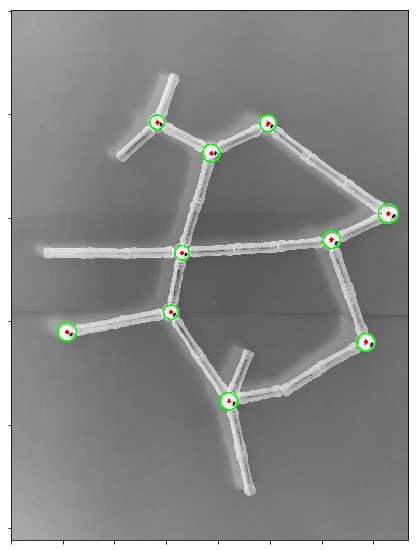

In [25]:
img_gray = cv2.imread(filename, 0)
img=cv2.bitwise_not(img_gray)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,10,param1=100,param2=22,minRadius=7,maxRadius=20)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # нарисовать окружности
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # нарисовать центры окружностей
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plot_image(cimg)

Далее объединялись выше примененные два способа поиска вершин, повторяющиеся вершины были убраны. Если евклидово расстояние между двумя вершинами было меньше 20, то такие вершины рассматривались как одни и те же.

**2) Определение степени вершин** <br>
Для определения степени вершины рисовалась окружность радиуса 55 с центром в данной вершине, и считалось количество пересечений окружности со скелетом. Функция vector строит описание топологической структуры графа в виде вектора, в котором k-я компонента есть число вершин степени k в представленном графе.

In [37]:
def scale_image_pixels(img):
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min()) * 255
    return img.astype(np.uint8)

In [28]:
def vector (points, balls, skel,rad=55):
    eps=20
    vertexes=balls.copy()
    vec=[0,0,0,0,0,0,0,0,0]
    for p in points:
        check=True
        for c in balls:
            if(np.linalg.norm(p-c)<eps):
                check=False
        if check:
            vertexes.append(p)
    for v in vertexes:
        white=np.ones(skel.shape).astype(np.uint8)*255#Белый фон
        cv2.circle(white,(v[0],v[1]),rad,(0,0,0),2) # Рисуем черного цвета окружность радиуса 55 с центром в вершине 
        ind=np.where(white==0)#Пиксели образующие окружность
        j=round(len(np.where(skel[ind]==0)[0])/24)-1 #Проверка на то, что пиксели в тех же координатах скелета -  черные
        #Число 24 подобрано эмирически, ориентируясь на толщину окружности и толщину скелета
        vec[j]+=1
        plot_image(white==skel)
        print(j+1,"   (",v[0],v[1],")")#Количество пересечений и координаты вершины
    return vec, vertexes

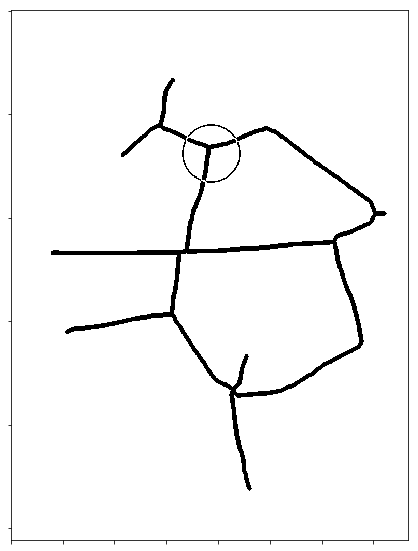

3    ( 386 278 )


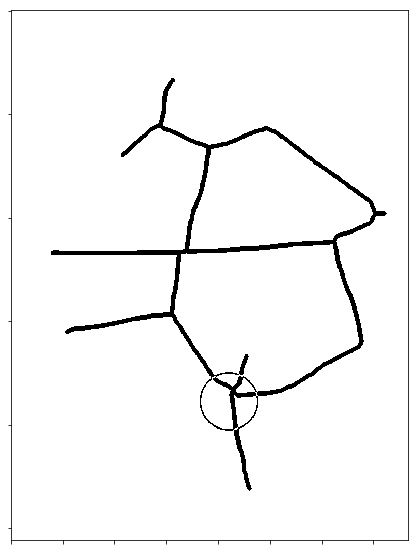

4    ( 420 756 )


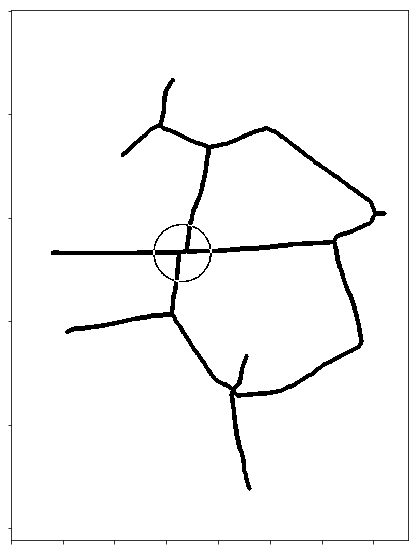

4    ( 330 470 )


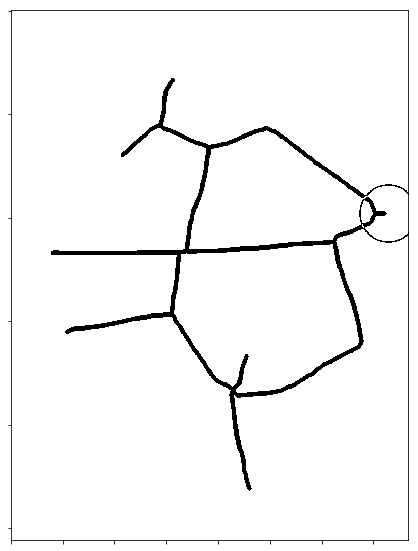

2    ( 728 394 )


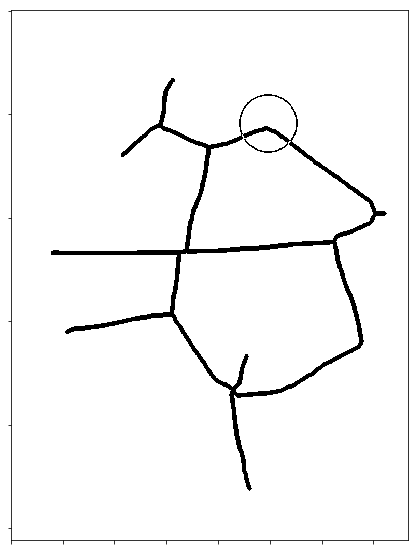

2    ( 496 220 )


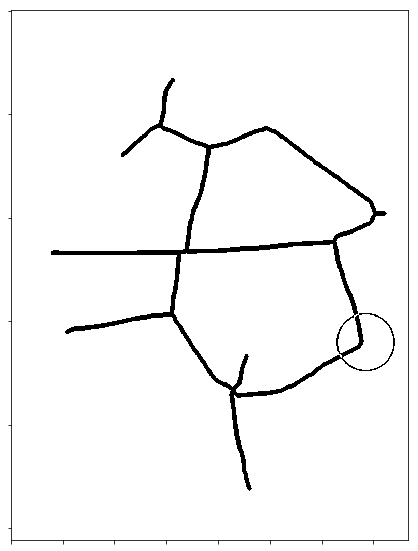

2    ( 684 642 )


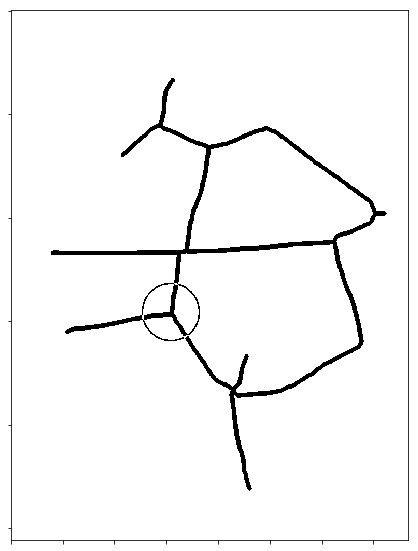

3    ( 308 584 )


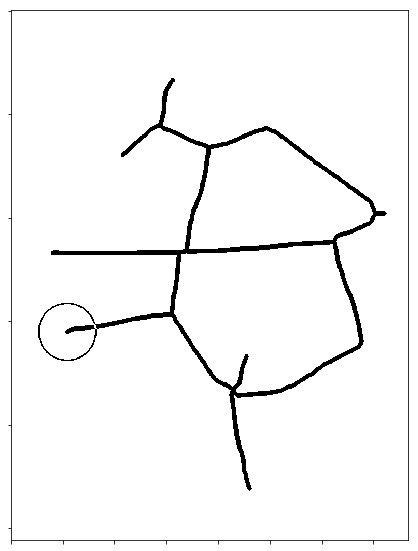

1    ( 108 622 )


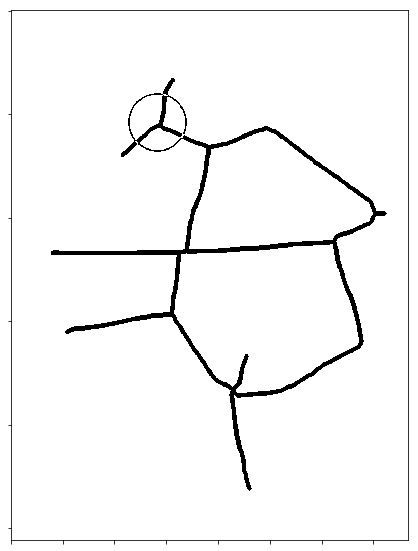

3    ( 282 218 )


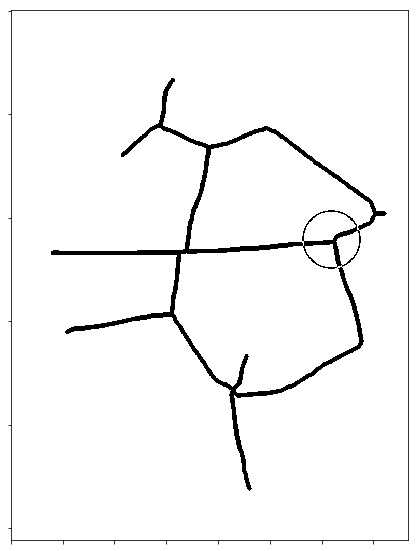

3    ( 618 444 )


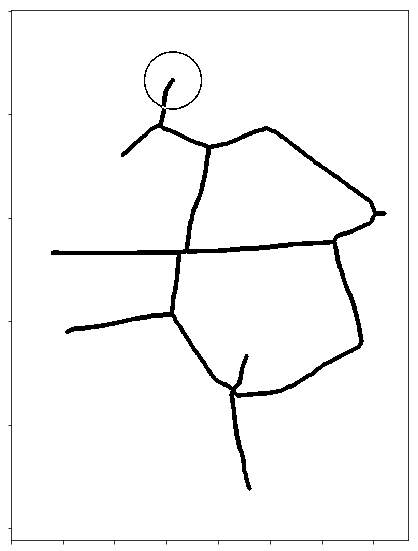

1    ( 312 137 )


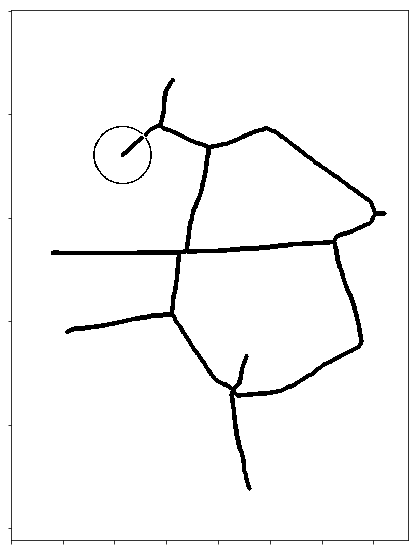

1    ( 215 281 )


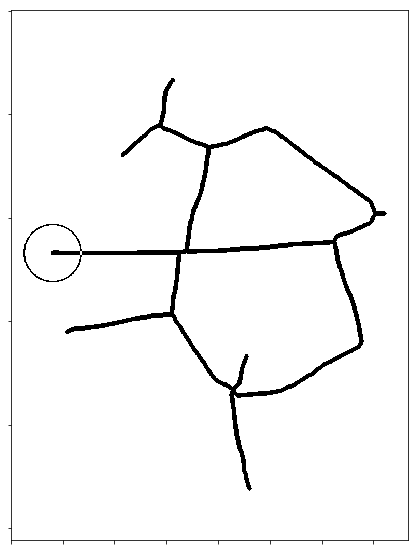

1    ( 80 470 )


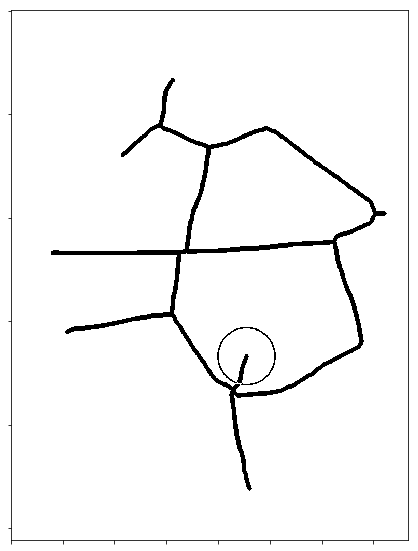

1    ( 454 669 )


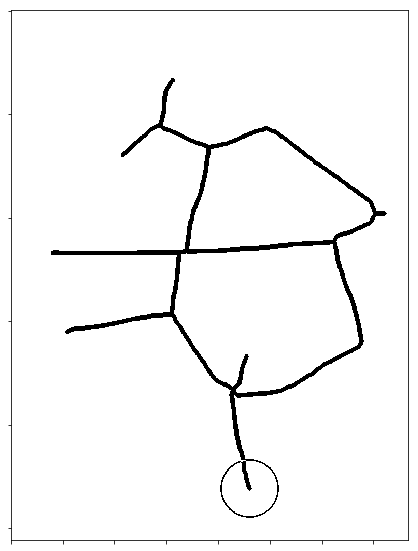

1    ( 460 924 )


In [12]:
vectors=[]
images=read("5.jpg")
for img in images:
    skeleton, skel, points = skeleton_ex_points(img,rad=55)
    balls=center_balls(img)
    vec, vertexes=vector(points, balls, skel)
    vectors.append(vec)
    
vectors=np.array(vectors)

In [15]:
print("Топологическая структура графа в виде вектора:")
vectors

Топологическая структура графа в фиде вектора:


array([[6, 3, 4, 2, 0, 0, 0, 0, 0]])

В качестве признакового описания топологической структуры графа (класса) был взят выше полученный вектор. На четырех структурах графов, эталоны которых представлены на изображениях 2.jpg (класс I), 3.jpg (класс II), 4.jpg (класс III), 5.jpg (класс IV), была обучена  логистическая регрессия. 

### 4. Выводы
В данной лабораторной работе нам пришлось решить такие задачи:
- построение скелета бинарного изображения;
- вычисление признаков топологической структуры графа на основе анализа скелета. <br>
Прежде чем строить скелет, для выделения маски под граф была использована бинаризация и дилатация бинарного изображения. <br>
Для вычисления признаков топологической структуры необходимо было найти все вершины графа, для чего мы воспользовались алгоритмом поиска концевых точек скелета и преобразованием Хафа для поиска координат магнитных шариков.
Степень вершин графа считалась как количество пересечений построенной окружности с центром в вершине графа со скелетом.  Вектор с перечислением количества вершин каждой степени служил в качестве признакового описания класса графа.
